*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [4]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [5]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2021-07-01 07:20:37--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  13.0MB/s    in 1.9s    

2021-07-01 07:20:40 (13.0 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [7]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})
print(df_books.head())
df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

         isbn  ...                author
0  0195153448  ...    Mark P. O. Morford
1  0002005018  ...  Richard Bruce Wright
2  0060973129  ...          Carlo D'Este
3  0374157065  ...      Gina Bari Kolata
4  0393045218  ...       E. J. W. Barber

[5 rows x 3 columns]


In [134]:
# add your code here - consider creating a new cell for each section of code
# remove from the dataset users with less than 200 ratings and books with less than 100 ratings
sub1_df_ratings = df_ratings[df_ratings.groupby('user').user.transform('count')>199].copy()
#print(sub1_df_ratings)
sub2_df_ratings = df_ratings[df_ratings.groupby('isbn').isbn.transform('count')>99].copy()
#print(sub2_df_ratings)
sub_df_ratings = sub1_df_ratings.loc[sub1_df_ratings['isbn'].isin(sub2_df_ratings['isbn'])]
print(sub_df_ratings.reset_index(drop=True))


         user        isbn  rating
0      277427  002542730X    10.0
1      277427  0060930535     0.0
2      277427  0060934417     0.0
3      277427  0061009059     9.0
4      277427  0140067477     0.0
...       ...         ...     ...
49776  275970  0804111359     0.0
49777  275970  140003065X     0.0
49778  275970  1400031346     0.0
49779  275970  1400031354     0.0
49780  275970  1400031362     0.0

[49781 rows x 3 columns]


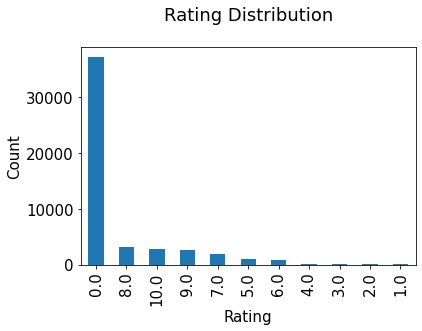

,rating,ratingCount
isbn,,
0971880107,0.435616,365
0316666343,3.198529,272
0060928336,1.909502,221
0440214041,1.885321,218
0385504209,3.170507,217
...,...,...
0552998486,2.869565,23
0451204530,1.565217,23
0684833395,2.500000,22


In [135]:
# EDA
plt.rc("font", size=15)
sub_df_ratings.rating.value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

average_rating = pd.DataFrame(sub_df_ratings.groupby('isbn')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(sub_df_ratings.groupby('isbn')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False)

In [136]:
# Convert to 2D matrix pivot table and replace NaN values with 0
ratings_pivot = sub_df_ratings.pivot(index='isbn', columns='user', values='rating').fillna(0)
print(ratings_pivot.shape)
ratings_pivot.head()


(731, 888)


user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# Prepare input as scipy sparse matrix for KNN model
mat_isbn_user_ratings=csr_matrix(ratings_pivot.values)
print(mat_isbn_user_ratings)
model = NearestNeighbors(metric = 'cosine')
model.fit(mat_isbn_user_ratings)

  (0, 25)	6.0
  (0, 27)	10.0
  (0, 122)	7.0
  (0, 148)	10.0
  (0, 198)	6.0
  (0, 220)	7.0
  (0, 242)	7.0
  (0, 328)	6.0
  (0, 335)	5.0
  (0, 386)	8.0
  (0, 467)	8.0
  (0, 504)	8.0
  (0, 540)	7.0
  (0, 546)	5.0
  (0, 577)	10.0
  (0, 650)	7.0
  (0, 653)	9.0
  (0, 702)	7.0
  (0, 719)	7.0
  (0, 733)	7.0
  (0, 867)	7.0
  (0, 884)	10.0
  (1, 25)	8.0
  (1, 398)	8.0
  (1, 408)	7.0
  :	:
  (729, 197)	8.0
  (729, 239)	8.0
  (729, 266)	8.0
  (729, 390)	8.0
  (729, 397)	9.0
  (729, 457)	7.0
  (729, 489)	10.0
  (729, 535)	8.0
  (729, 567)	10.0
  (729, 657)	8.0
  (729, 796)	8.0
  (729, 798)	10.0
  (729, 875)	10.0
  (730, 107)	10.0
  (730, 115)	8.0
  (730, 132)	6.0
  (730, 284)	10.0
  (730, 308)	2.0
  (730, 373)	10.0
  (730, 458)	7.0
  (730, 488)	8.0
  (730, 501)	3.0
  (730, 563)	10.0
  (730, 675)	3.0
  (730, 861)	7.0


NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [151]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  initial_book=book
# change the input book title to isbn x user 2D matrix pivot table
  book=sub_df_books.loc[sub_df_books["title"]==book]
  input_isbn=ratings_pivot.loc[ratings_pivot.index.isin(book['isbn'])]
  print(input_isbn)
  # Store results in distance and indice arrays
  distance,indice=model.kneighbors([x for x in input_isbn.values],n_neighbors=6)
  print(distance)
  # transform to 1D array removing 1st index for self
  distance =  distance[0][1:]
  indice = indice[0][1:]
  
  titles = [
      df_books.loc[df_books['isbn'] == ratings_pivot.iloc[i].name]["title"].values[0]\
      for i in indice
  ]

  recommended = [list(z) for z in zip(titles, distance)][::-1]
  return [initial_book, recommended]


Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [152]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

user        254     2276    2766    2977    ...  277427  277478  277639  278418
isbn                                        ...                                
0446672211     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[1 rows x 888 columns]
[[0.         0.7234864  0.7677075  0.7699411  0.77085835 0.8016211 ]]
[[435 108  27 182 120 625]]
[108  27 182 120 625]
["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
user        254     2276    2766    2977    ...  277427  277478  277639  278418
isbn                                        ...                                
0446672211     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[1 rows x 888 columns]
[[0.         0.7234864  0.7677075  0.7699411  0.77085835 0.8016211 ]]
[[435 108  27 182 120 625]]
[108  27 182 1